In [2]:
from MiniTorch.nets.base import Net
from MiniTorch.nets.layers import Conv2D, Linear, MaxPool2d, PReLU, ReLU, SoftMax, Flatten, Tanh, Sigmoid
from MiniTorch.optimizers import SGD
from MiniTorch.losses import CCE, MSE
import matplotlib.pyplot as plt
import jax
import time
from MiniTorch.plotutils import show_conv_out
import jax.numpy as jnp
import torchvision

In [3]:
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
X = cifar10_train.data

In [4]:
Y = []
for i in cifar10_train.targets:
    temp = [0]*10
    temp[i] = 1
    Y.append(temp)

In [5]:
Y = cifar10_train.targets

In [6]:
def prepare_data(X,Y):
    X = jnp.array(X)
    Y = jnp.array(Y)
    X = jnp.reshape(X,(X.shape[0],X.shape[3],X.shape[1],X.shape[2]))
    X = X/255.
    return X,Y
X,Y = prepare_data(X,Y)

In [5]:
def yield_batches(X, Y, batch_size):
    """
    Yields batches of data and labels of the specified batch size.
    
    Args:
        X (numpy.ndarray): Input data array of shape (n_samples, ...) where ... is the feature shape.
        Y (numpy.ndarray): Label array of shape (n_samples, ...).
        batch_size (int): Size of each batch.
    
    Yields:
        tuple: (batch_X, batch_Y) where each is a slice of X and Y of size batch_size
               (or smaller for the last batch if n_samples % batch_size != 0).
    """
    n_samples = X.shape[0]
    
    # Ensure X and Y have compatible shapes
    assert n_samples == Y.shape[0], "Number of samples in X and Y must match"
    
    # Iterate over the dataset in chunks of batch_size
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        yield X[start_idx:end_idx], Y[start_idx:end_idx]

In [7]:
net = Net(
    [
        Conv2D(3,4,20, accumulate_grad_norm=True, accumulate_params=True),
        MaxPool2d(2,2),
        Flatten(),
        Linear(3920, 50, accumulate_grad_norm=True,accumulate_parameters=True),
        # PReLU(accumulate_grad_norm=True,accumulate_parameters=True),
        Linear(50, 50, accumulate_grad_norm=True,accumulate_parameters=True),
        Sigmoid(),
        Linear(50, 10,accumulate_grad_norm=True,accumulate_parameters=True),
        SoftMax()
    ],
    reproducibility_key=20
)

In [8]:
epochs = 10
batch_size = 100
crit = CCE()
optimizer = SGD(0.0001,net)

In [9]:
for epoch in range(epochs):
    epoch_loss = 0
    for X_train, Y_train in yield_batches(X,Y,batch_size):
        pred = net.forward(X_train)
        loss = crit.loss(pred,Y_train)
        ini_grad = crit.backward(loss)
        optimizer.step(ini_grad)
        epoch_loss += loss
    print(f"Loss for {epoch}/{epochs} -> {epoch_loss/1000}")

Loss for 0/10 -> 1.586605429649353
Loss for 1/10 -> 1.2125096321105957
Loss for 2/10 -> 1.178550362586975
Loss for 3/10 -> 1.1642783880233765
Loss for 4/10 -> 1.1591018438339233
Loss for 5/10 -> 1.1583945751190186
Loss for 6/10 -> 1.1539652347564697
Loss for 7/10 -> 1.1560667753219604
Loss for 8/10 -> 1.1588398218154907
Loss for 9/10 -> 1.1556099653244019


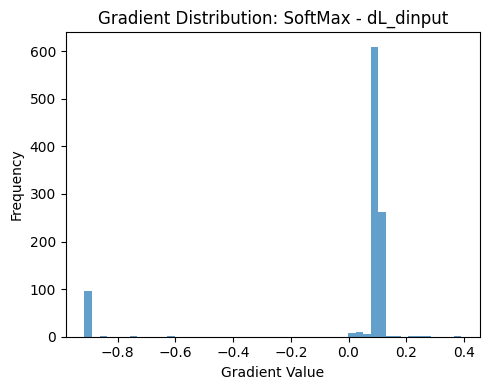

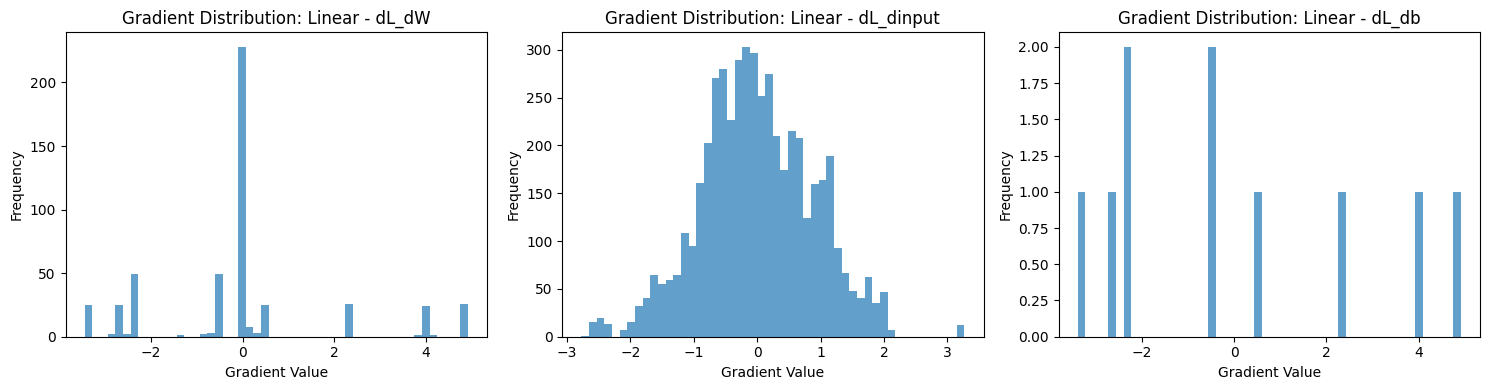

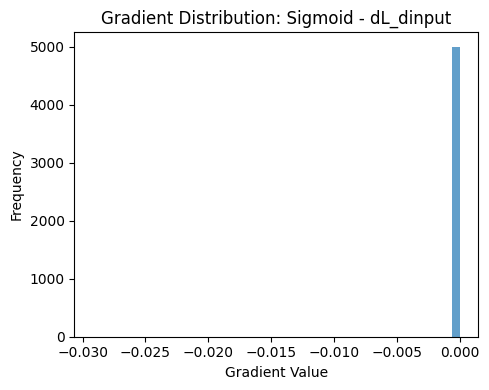

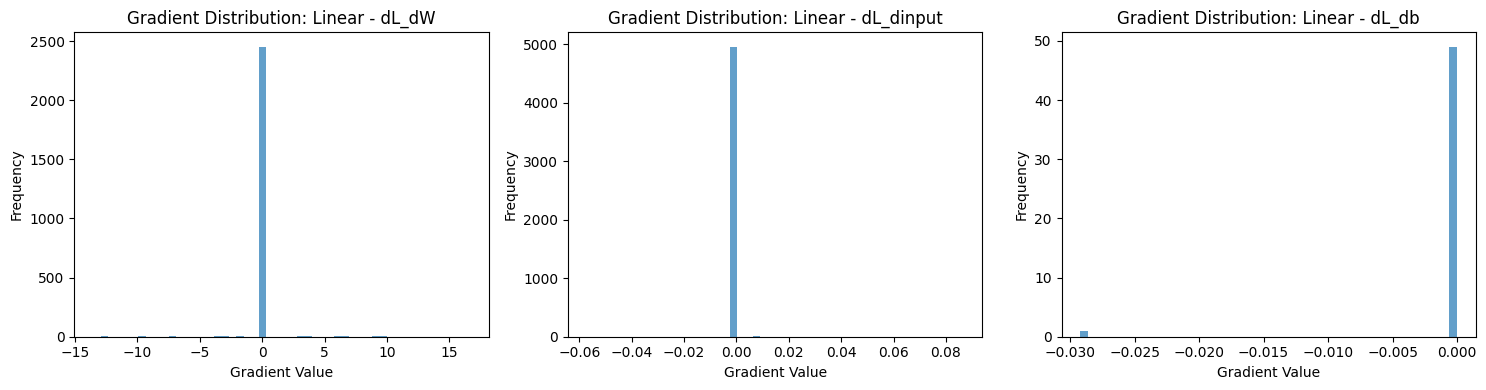

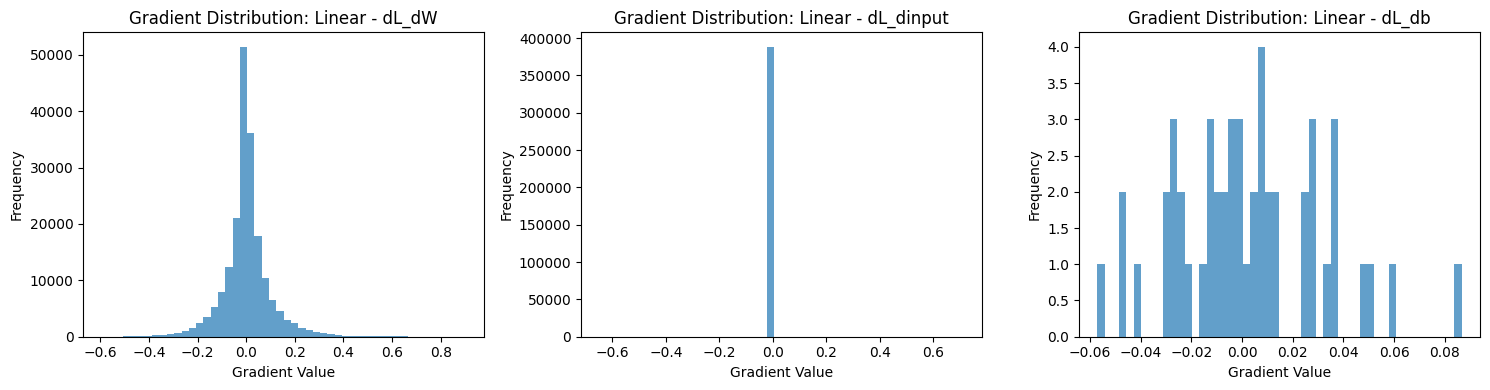

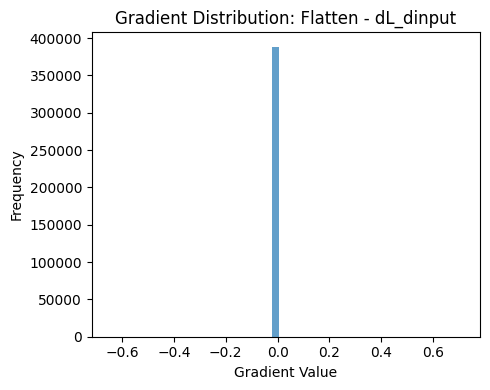

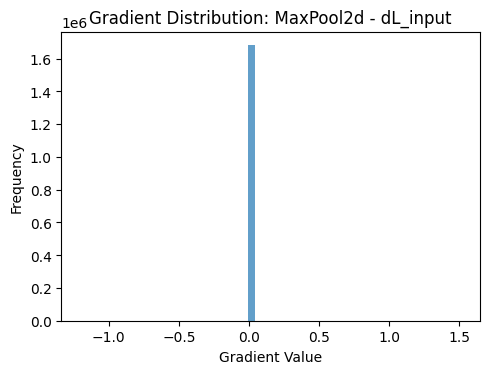

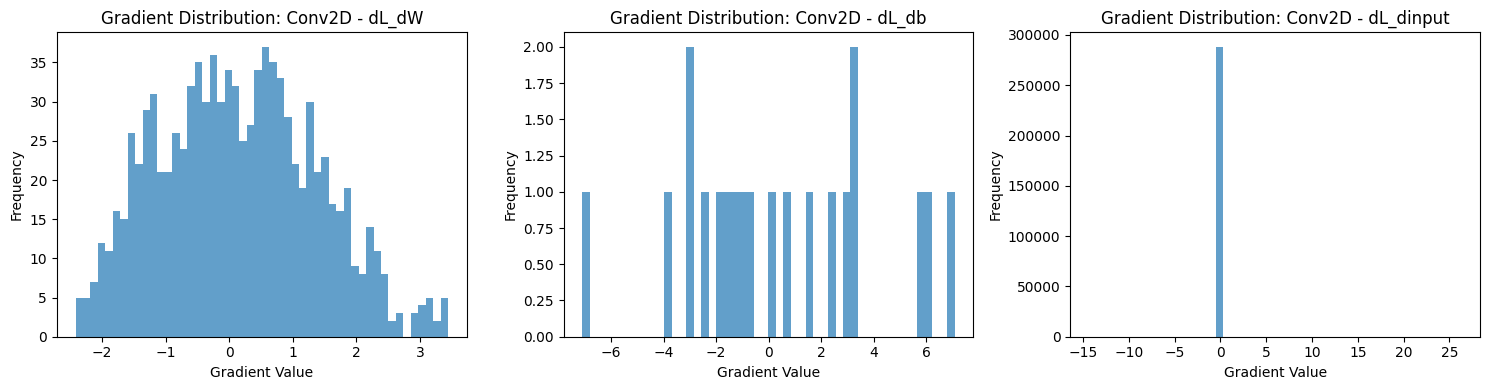

In [10]:
net.plot_backprop_grad_dist()

In [11]:
Y[0]

Array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [21]:
net.layers[1].grad_cache['dL_input'].min()

Array(-1.2026109, dtype=float32)

In [22]:
net.print_gradient_info()

------------------- Linear 6 --------------------
Grad dL_dW Variance and Mean -> 3.9213883876800537 , -5.793571844492362e-08
Grad dL_dinput Variance and Mean -> 0.7803163528442383 , 0.003359961323440075
Grad dL_db Variance and Mean -> 7.5504560470581055 , -5.185603981772147e-07
------------------- Linear 4 --------------------
Grad dL_dW Variance and Mean -> 1.1920757293701172 , 0.022334419190883636
Grad dL_dinput Variance and Mean -> 8.305527444463223e-06 , 2.2111769794719294e-05
Grad dL_db Variance and Mean -> 1.6706879250705242e-05 , -0.0005839148070663214
------------------- Linear 3 --------------------
Grad dL_dW Variance and Mean -> 0.010365285910665989 , 0.0027645949739962816
Grad dL_dinput Variance and Mean -> 0.0004064745153300464 , 2.0568448235280812e-05
Grad dL_db Variance and Mean -> 0.0008257126901298761 , 0.002211177023127675
------------------- Conv2D 0 --------------------
Grad dL_dW Variance and Mean -> 1.5098040103912354 , 0.134225532412529
Grad dL_db Variance and M

In [23]:
net.print_variance_info()

Conv2D 0
Weights Variance and Mean -> (Array(1.0751936, dtype=float32), Array(-0.02704714, dtype=float32))
Bias Variance and Mean -> (Array(0.0491158, dtype=float32), Array(-0.01011733, dtype=float32))
Input Variance and Mean -> (Array(0.06503627, dtype=float32), Array(0.48743293, dtype=float32))
Output Variance and Mean -> (Array(26.753569, dtype=float32), Array(-0.6490428, dtype=float32))
Linear 3
Weights Variance and Mean -> (Array(0.9995936, dtype=float32), Array(-0.00167337, dtype=float32))
Bias Variance and Mean -> (Array(3.4409045e-06, dtype=float32), Array(-0.00025849, dtype=float32))
Input Variance and Mean -> (Array(26.28645, dtype=float32), Array(0.14231329, dtype=float32))
Output Variance and Mean -> (Array(136325.27, dtype=float32), Array(-39.497738, dtype=float32))
Linear 4
Weights Variance and Mean -> (Array(0.9810503, dtype=float32), Array(-0.02226774, dtype=float32))
Bias Variance and Mean -> (Array(9.211648e-08, dtype=float32), Array(8.635917e-06, dtype=float32))
Inpu

In [5]:
net = Net(
    [
        Conv2D(3,4,5, accumulate_grad_norm=True, accumulate_params=True, initialization="he"),
        MaxPool2d(2,2),
        Flatten(),
        Linear(980, 50, accumulate_grad_norm=True,accumulate_parameters=True, initialization="he"),
        # PReLU(accumulate_grad_norm=True,accumulate_parameters=True),
        Sigmoid(),
        Linear(50, 10,accumulate_grad_norm=True,accumulate_parameters=True, initialization="he"),
        Linear(10,1,accumulate_grad_norm=True,accumulate_parameters=True, initialization="he")
    ],
    reproducibility_key=20
)

In [8]:
Y.shape

(50000,)

In [7]:
epochs = 10
batch_size = 100
crit = MSE()
optimizer = SGD(0.0001,net)

In [10]:
for epoch in range(epochs):
    epoch_loss = 0
    for X_train, Y_train in yield_batches(X,Y,batch_size):
        pred = net.forward(X_train)
        loss = crit.loss(pred,Y_train)
        ini_grad = crit.backward(loss)
        optimizer.step(ini_grad)
        epoch_loss += loss
    print(f"Loss for {epoch}/{epochs} -> {epoch_loss/1000}")

NameError: name 'yield_batches' is not defined

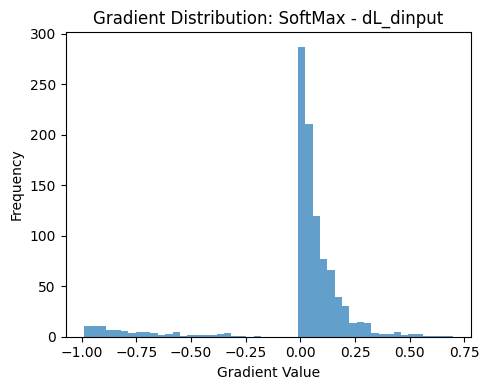

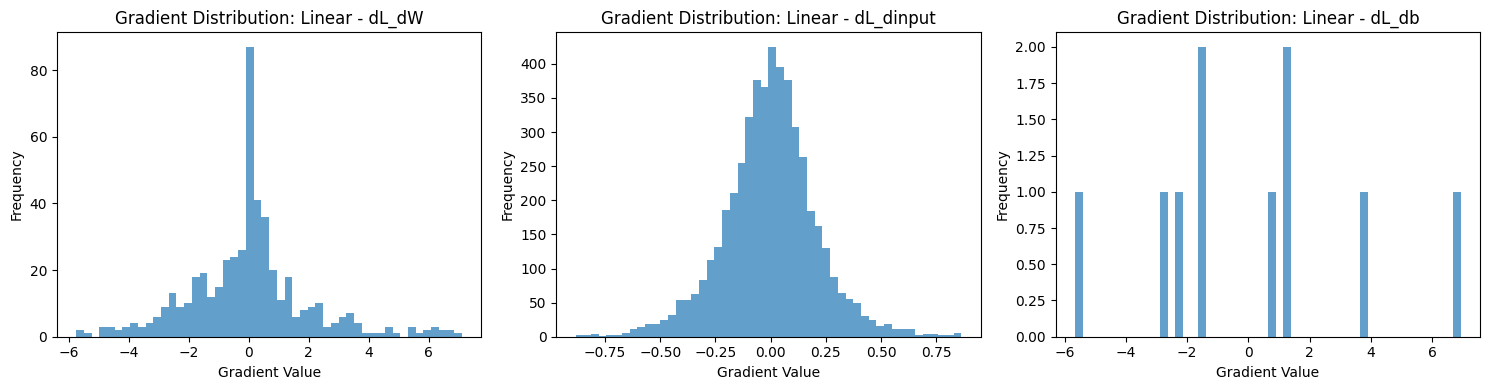

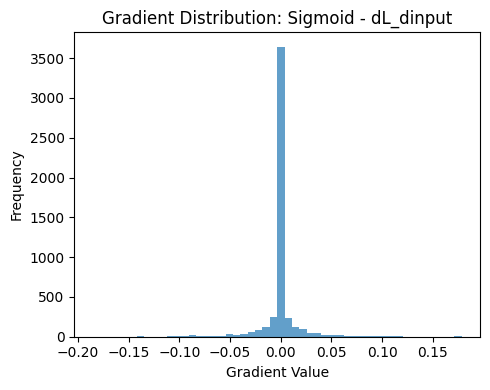

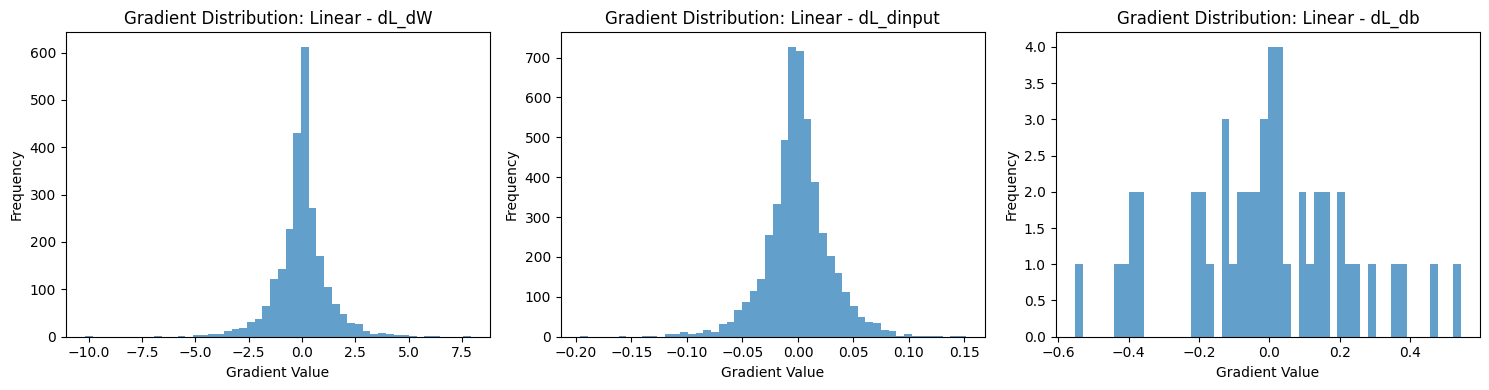

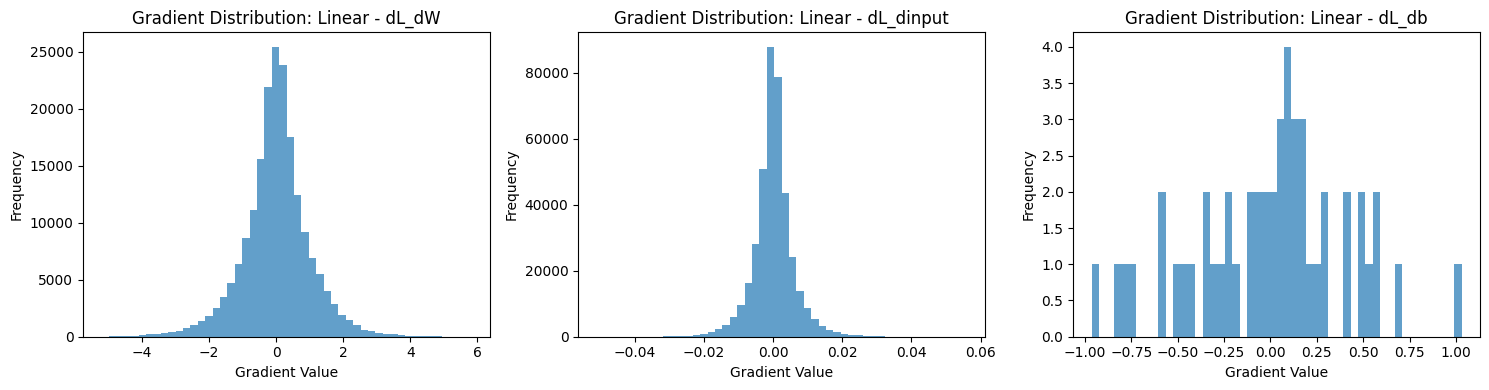

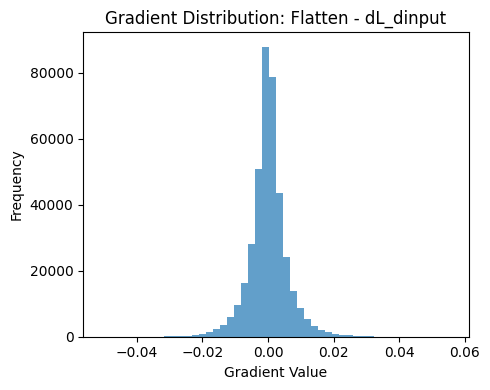

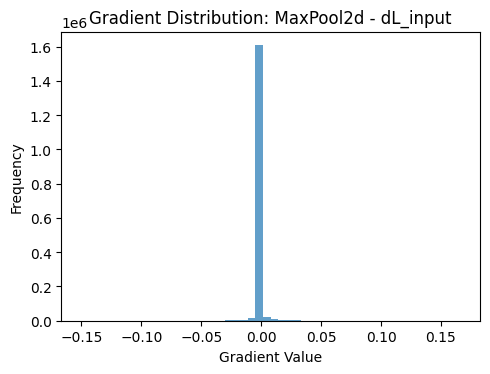

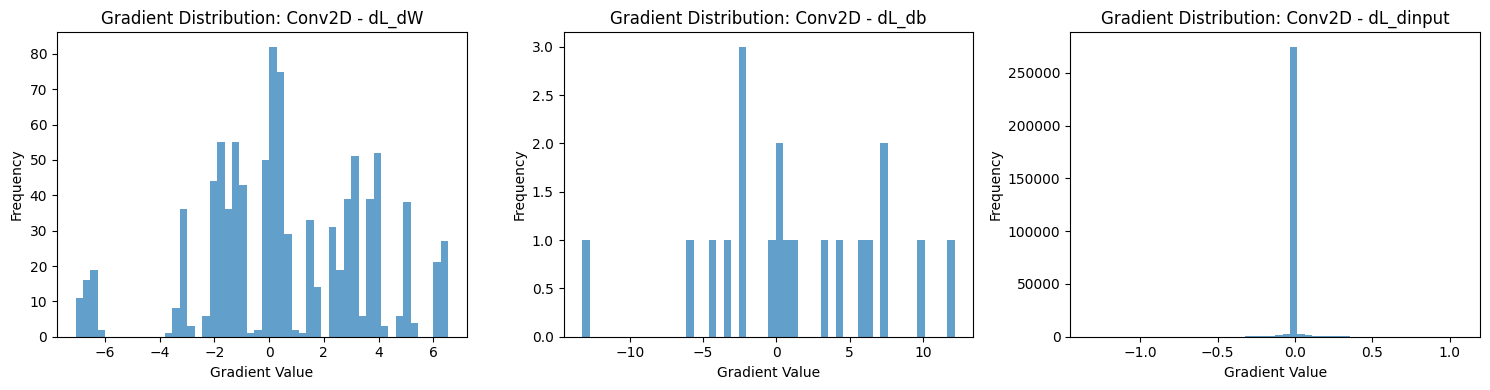

In [9]:
net.plot_backprop_grad_dist()

In [11]:
def calc_loss(w1,w2,X,Y):
    net.layers[-2].parameters['W'] = net.layers[-2].parameters['W'].at[0,0].set(w1)
    net.layers[-2].parameters['W'] = net.layers[-2].parameters['W'].at[0,1].set(w2)
    out = net.forward(X)
    loss = crit.loss(out,Y)
    ini_grad = crit.backward(loss)
    net.backward(ini_grad)
    gradw1 = net.layers[-2].grad_cache['dL_dW'][0][0]
    gradw2 = net.layers[-2].grad_cache['dL_dW'][0][1]
    return loss, gradw1, gradw2

In [9]:
import numpy as np

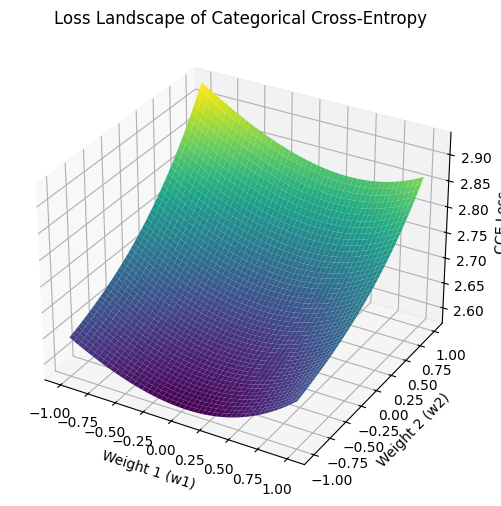

In [ ]:
w1_vals = np.linspace(-1, 1, 50)  # Adjust based on trained weight range
w2_vals = np.linspace(-1, 1, 50)
loss_vals = np.zeros((50, 50))

# Compute loss for each (w1, w2) pair
for i, w1 in enumerate(w1_vals):
    for j, w2 in enumerate(w2_vals):
        loss_vals[i, j] = calc_loss(w1, w2)[0]

# Plot the loss landscape
W1, W2 = np.meshgrid(w1_vals, w2_vals)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(W1, W2, loss_vals, cmap="viridis")
ax.set_xlabel("Weight 1 (w1)")
ax.set_ylabel("Weight 2 (w2)")
ax.set_zlabel("CCE Loss")
plt.title("Loss Landscape of Categorical Cross-Entropy")
plt.show()

In [ ]:
w1_vals = np.linspace(-1, 1, 50)
w2_vals = np.linspace(-1, 1, 50)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
dL_dW1 = np.zeros_like(W1)
dL_dW2 = np.zeros_like(W2)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        loss, grad_w1, grad_w2 = calc_loss(W1[i, j], W2[i, j])
        dL_dW1[i, j] = grad_w1
        dL_dW2[i, j] = grad_w2


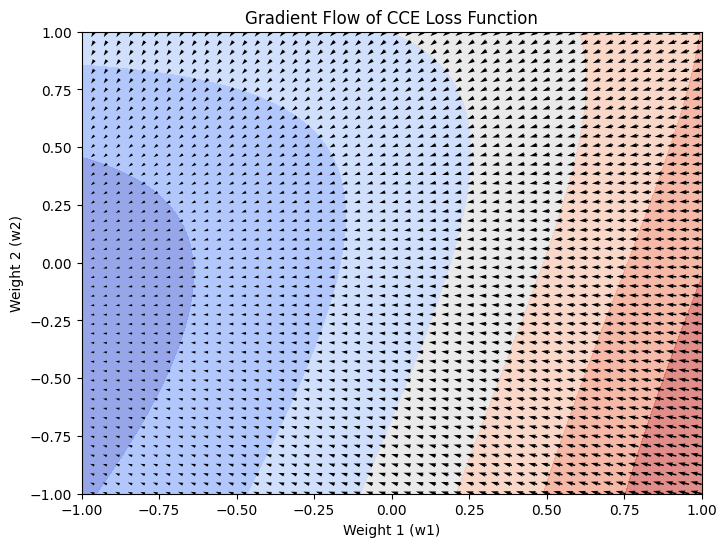

In [ ]:
plt.figure(figsize=(8, 6))
plt.contourf(W1, W2, np.log(1 + dL_dW1**2 + dL_dW2**2), cmap="coolwarm", alpha=0.6)
plt.quiver(W1, W2, -dL_dW1, -dL_dW2, color="black")
plt.xlabel("Weight 1 (w1)")
plt.ylabel("Weight 2 (w2)")
plt.title("Gradient Flow of CCE Loss Function")
plt.show()


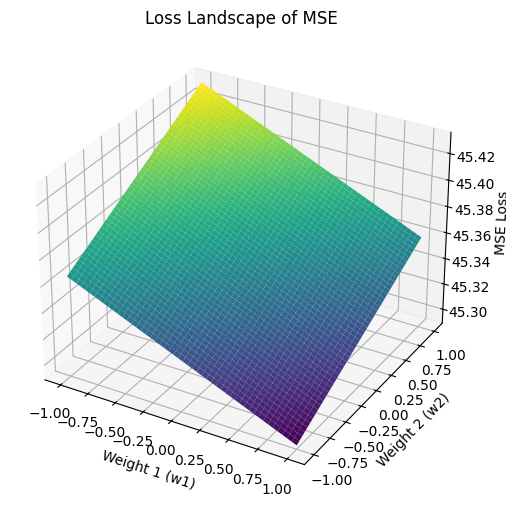

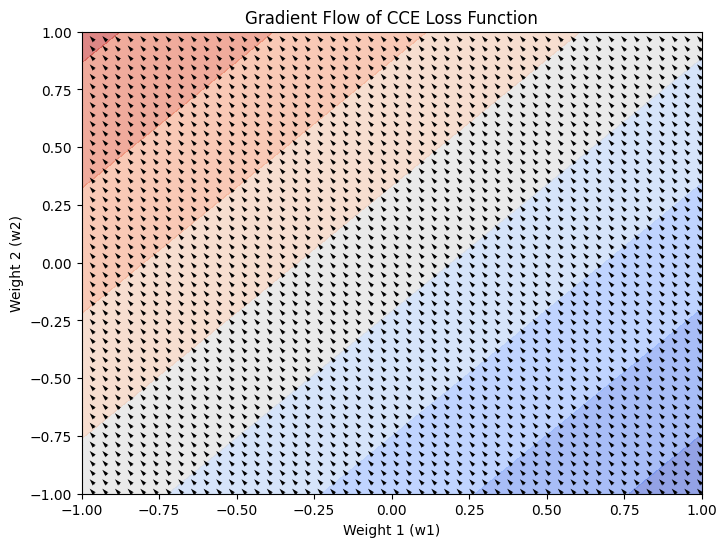

In [ ]:
w1_vals = np.linspace(-1, 1, 50)
w2_vals = np.linspace(-1, 1, 50)
loss_vals = np.zeros((50, 50))

w1_vals = np.linspace(-1, 1, 50)
w2_vals = np.linspace(-1, 1, 50)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
dL_dW1 = np.zeros_like(W1)
dL_dW2 = np.zeros_like(W2)

for i, w1 in enumerate(w1_vals):
    for j, w2 in enumerate(w2_vals):
        loss_vals[i, j], grad_w1, grad_w2 = calc_loss(w1, w2, jnp.expand_dims(X[0],axis=0),jnp.expand_dims(Y[0],axis=0))
        dL_dW1[i,j] = grad_w1
        dL_dW2[i,j] = grad_w2
loss_vals = jnp.nan_to_num(loss_vals,posinf=1000,neginf=1000)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(W1, W2, loss_vals, cmap="viridis")
ax.set_xlabel("Weight 1 (w1)")
ax.set_ylabel("Weight 2 (w2)")
ax.set_zlabel("MSE Loss")
plt.title("Loss Landscape of MSE")
plt.show()

plt.figure(figsize=(8, 6))
plt.contourf(W1, W2, np.log(1 + dL_dW1**2 + dL_dW2**2), cmap="coolwarm", alpha=0.6)
plt.quiver(W1, W2, -dL_dW1, -dL_dW2, color="black")
plt.xlabel("Weight 1 (w1)")
plt.ylabel("Weight 2 (w2)")
plt.title("Gradient Flow of MSE Loss Function")
plt.show()


In [19]:
print(loss_vals)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
jnp.nan_to_num(loss_vals,posinf=1000,neginf=1000)

Array([[17.627789, 18.232668, 18.905441, ...,  0.      ,  0.      ,
         0.      ],
       [17.798729, 18.422028, 19.117672, ...,  0.      ,  0.      ,
         0.      ],
       [17.974682, 18.617567, 19.337687, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [34]:
import jax.numpy as jnp
import jax
from MiniTorch.core.baseclasses import ComputationNode
class BatchNorm(ComputationNode):

    def __init__(self):
        super().__init__()
        self.gamma = 1
        self.beta = 0
        self.parameters = {'gamma' : 1, 'beta' : 0}
        self.mu_ = None
        self.std_ = None
        self.input_ = None
        self.eps = 0.00000000001

    @staticmethod
    @jax.jit
    def batch_norm_fwd(input, gamma, beta,eps):
        mu_ = jnp.mean(input,axis=(0,))
        std_ = jnp.sqrt(jnp.var(input,axis=(0,)) + eps)
        input_ = (input - mu_)/std_
        output = gamma * input_ + beta
        return output, mu_, std_, input_
    
    def forward(self, input : jax.Array):
        self.input = input
        self.output, self.mu_, self.std_, self.input_ = self.batch_norm_fwd(input,self.parameters['gamma'], self.parameters['beta'],self.eps)
        return self.output
    
    @staticmethod
    @jax.jit
    def batch_norm_bwd(input_,input,gamma,output_grad,eps, mu_):
        dL_dgamma = jnp.sum(input_ * output_grad)
        dL_dbeta = jnp.sum(output_grad)
        dL_dinput_ = gamma * output_grad
        var_ = jnp.var(input,axis=(0,))
        dL_dvar =  -1/2 * jnp.power(var_ + eps,-3/2) * jnp.sum(dL_dinput_ * (input - mu_), axis=(0,))
        dL_dmu = jnp.sum((-jnp.power(var_+eps,-1/2) * dL_dinput_) + dL_dvar * -2 * (input-mu_), axis=(0,))
        dL_dinput = jnp.power(var_+eps,-1/2) * dL_dinput_ + 2 * jnp.sum(input - mu_, axis=(0,)) * dL_dvar + 1/input.shape[0] * dL_dmu
        return dL_dinput, dL_dgamma, dL_dbeta 

    
    def backward(self, output_grad):
        
        self.grad_cache['dL_dinput'], self.grad_cache['dL_dgamma'], self.grad_cache['dL_dbeta'] = self.batch_norm_bwd(self.input_,self.input,self.parameters['gamma'],output_grad,self.eps,self.mu_)

        return self.grad_cache['dL_dinput']

In [35]:
batch_norm = BatchNorm()

In [36]:
out = batch_norm.forward(X)

In [37]:
import numpy as np
shape = list(out.shape)
grad = np.random.randn(*shape)

In [38]:
grad = batch_norm.backward(grad)

In [40]:
grad.shape

(50000, 3, 32, 32)